In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import torch
sys.path.append('../../src')

from m3_learning.viz.layout import layout_fig
from m3_learning.RHEED.Viz import Viz
from m3_learning.RHEED.Dataset import RHEED_parameter_dataset, RHEED_spot_Dataset
from m3_learning.RHEED.Analysis_umich import fit_curves, analyze_rheed_data, select_range, plot_activation_energy
from m3_learning.RHEED.Fitter1D import Model, Multiscale1DFitter


def collect_data(ys_nor_all, mean_length=2000, viz=False):

    ys_all_same_length = []
    for y in ys_nor_all:
        ys_all_same_length.append(np.interp(np.linspace(0, 1, mean_length), np.linspace(0, 1, len(y)), y))

    ys_all_same_length = np.array(ys_all_same_length)
    ys = torch.tensor(ys_all_same_length).float().unsqueeze(1)

    x = np.linspace(0, 1, mean_length)
    x = torch.tensor(x).float().unsqueeze(0)

    xs = x.repeat(ys.shape[0], 1, 1).squeeze().detach().numpy()
    if viz:
        print(xs.shape, ys.shape)
        Viz.plot_fit_details(xs, ys.squeeze().detach().numpy(), ys.squeeze().detach().numpy(), None, mod=5, labels=None, figsize=(12, 1.5*len(xs)//4+1), style='presentation')
    return xs, ys

def viz_fit(model, batch, device):
    inputs = batch[0].to(device).double()
    model = model.to(device).double()
    outputs, unscaled_param = model(inputs)
    labels = []
    for param in unscaled_param:
        labels.append(f'I/I0 = {param[0]:.2f} * 1-exp(-x/{param[1]:.2e})')

    xs = x.repeat(outputs.shape[0], 1, 1).squeeze().detach().cpu().numpy()
    ys = inputs.squeeze().detach().cpu().numpy()
    ys_fit = outputs.squeeze().detach().cpu().numpy()
    # print(xs.shape, ys.shape, ys_fit.shape)
    Viz.plot_fit_details(xs, ys, ys_fit, None, mod=5, labels=labels, figsize=(12, 1.5*len(xs)//4+1), style='presentation')

In [92]:
def find_sign_change(values, rule='increase_to_decrease', window=10, threshold=8):

    for i in range(window, len(values)-window):
        increase_count, decrease_count = 0, 0
        if rule == 'increase_to_decrease': 
            for j in range(i-window, i):
                # print(j, j+1)
                if values[j] < values[j+1]:
                    increase_count += 1
            for j in range(i, i+window):
                if values[j] > values[j+1]:
                    decrease_count += 1
            # print(increase_count, decrease_count)
            if increase_count >= threshold and decrease_count >= threshold:
                    return i
        elif rule == 'decrease_to_increase': 
            for j in range(i-window, i):
                if values[j] > values[j+1]:
                    decrease_count += 1
            for j in range(i, i+window):
                if values[j] < values[j+1]:
                    increase_count += 1
            if increase_count >= threshold and decrease_count >= threshold:
                    return i
        else:
            # print('Cannot find trend change point.')
            return -1

    # return trend_inc, trend_dec
values = [0, 0, 0, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 7, 6, 5, 4, 3, 2, 1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
print(find_sign_change(values, rule='increase_to_decrease', window=10, threshold=8))

values = [0, 0, 0, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 7, 6, 5, 4, 3, 2, 1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
print(find_sign_change(values, rule='decrease_to_increase', window=10, threshold=8))

values = [0, 0, 0, 0, 0, 0, 6, 7, 8, 9, 8, 7, 6, 5, 4, 3, 2, 1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
print(find_sign_change(values))

values = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 1, 1, 1, 1, 1, 3, 2, 1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
print(find_sign_change(values))

11
20
None
None


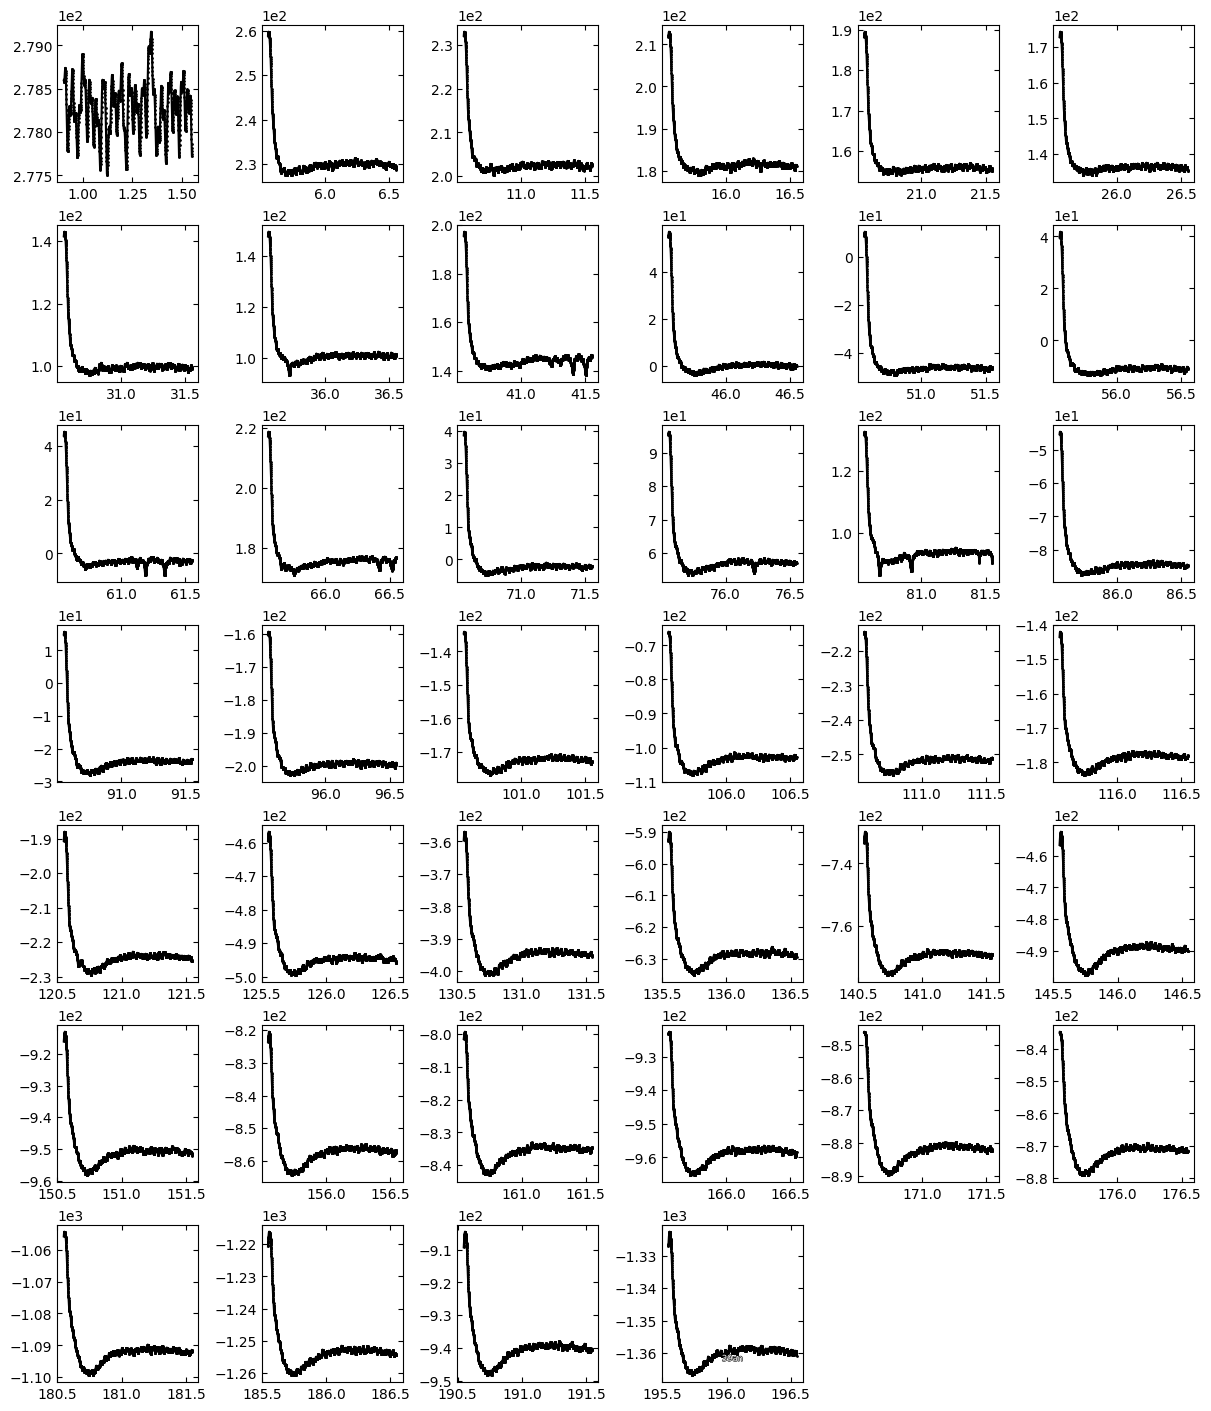

In [107]:
denoise_params = {'savgol_window_order': (51, 3), 'pca_component': None, 'fft_cutoff_order':(5, 1), 'median_kernel_size':51}
curve_params = {'trim_first':0, 'tune_tail':True, 'linear_ratio':0.6, 'convolve_step':15, 'prominence':0.2, 'mode':'full'}
normalize_params = {'I_diff': None, 'unify':True, 'bounds':[0.01, 1], 'p_init':(1, 0.1, 0.4), 'n_std':1}
viz_params = {'viz_denoise': False, 'viz_raw_curves': False, 'viz_processed_curves':True, 'viz_fittings': False, 'viz_ab': False, 'viz_tau': False, 'per_plot':5}
    
laser_freq = 1
camera_freq = 2000

ranges_list = [(0, 200)]
temp_list = ['temp350']
ys_list = []

para_path = './Datasets/J14_PM04_05_06_gaussian_fit_parameters_08252023.h5'
ds_para = RHEED_parameter_dataset(para_path, camera_freq=camera_freq, sample_name='J14')
for temp, ranges in zip(temp_list, ranges_list):
    sample_x, sample_y = ds_para.load_curve(growth=temp, spot='spot_2', metric='img_rec_max', x_start=0)
    # print(temp)
    data = np.stack([sample_x, sample_y], 1)
    data = select_range(data, *ranges)

    parameters_all, x_list_all, info, tau = analyze_rheed_data(data, camera_freq, laser_freq, denoise_params, curve_params, normalize_params, viz_params)
    [xs_all, ys_all, ys_fit_all, ys_nor_all, ys_nor_fit_all, ys_nor_fit_failed_all, labels_all, losses_all] = info
    xs, ys = collect_data(ys_all, mean_length=2000, viz=False)   

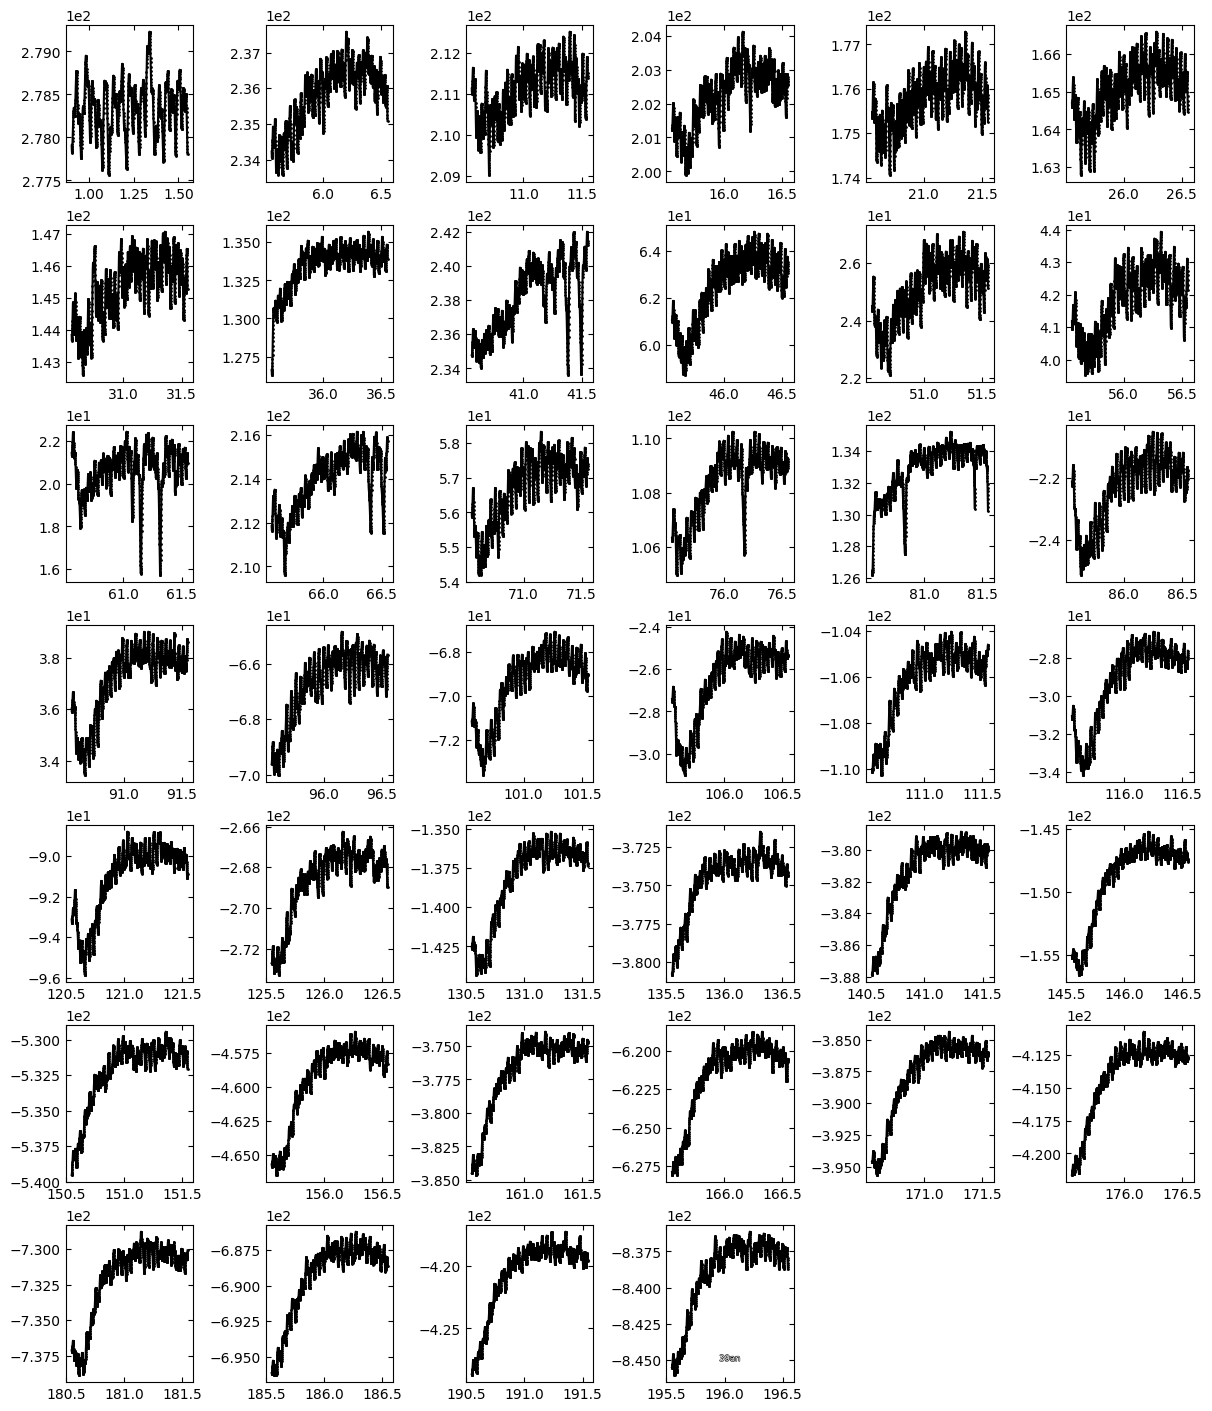

In [108]:
denoise_params = {'savgol_window_order': (51, 3), 'pca_component': None, 'fft_cutoff_order':(5, 1), 'median_kernel_size':51}
curve_params = {'trim_first':'decrease_to_increase', 'tune_tail':True, 'linear_ratio':0.6, 'convolve_step':15, 'prominence':0.2, 'mode':'full'}
normalize_params = {'I_diff': None, 'unify':True, 'bounds':[0.01, 1], 'p_init':(1, 0.1, 0.4), 'n_std':1}
viz_params = {'viz_denoise': False, 'viz_raw_curves': False, 'viz_processed_curves':True, 'viz_fittings': False, 'viz_ab': False, 'viz_tau': False, 'per_plot':5}
    
laser_freq = 1
camera_freq = 2000

ranges_list = [(0, 200)]
temp_list = ['temp350']
ys_list = []

para_path = './Datasets/J14_PM04_05_06_gaussian_fit_parameters_08252023.h5'
ds_para = RHEED_parameter_dataset(para_path, camera_freq=camera_freq, sample_name='J14')
for temp, ranges in zip(temp_list, ranges_list):
    sample_x, sample_y = ds_para.load_curve(growth=temp, spot='spot_2', metric='img_rec_max', x_start=0)
    # print(temp)
    data = np.stack([sample_x, sample_y], 1)
    data = select_range(data, *ranges)

    parameters_all, x_list_all, info, tau = analyze_rheed_data(data, camera_freq, laser_freq, denoise_params, curve_params, normalize_params, viz_params)
    [xs_all, ys_all, ys_fit_all, ys_nor_all, ys_nor_fit_all, ys_nor_fit_failed_all, labels_all, losses_all] = info
    xs, ys = collect_data(ys_all, mean_length=2000, viz=False)   

In [101]:
def find_sign_change(values, rule='increase_to_decrease', window=20, threshold=16):

    for i in range(window, len(values)-window):
        increase_count, decrease_count = 0, 0
        if rule == 'increase_to_decrease': 
            for j in range(i-window, i):
                # print(j, j+1)
                if values[j] < values[j+1]:
                    increase_count += 1
            for j in range(i, i+window):
                if values[j] > values[j+1]:
                    decrease_count += 1
            # print(increase_count, decrease_count)
            if increase_count >= threshold and decrease_count >= threshold:
                    return i
        elif rule == 'decrease_to_increase': 
            for j in range(i-window, i):
                if values[j] > values[j+1]:
                    decrease_count += 1
            for j in range(i, i+window):
                if values[j] < values[j+1]:
                    increase_count += 1
            if increase_count >= threshold and decrease_count >= threshold:
                    return i
        else:
            # print('Cannot find trend change point.')
            return -1

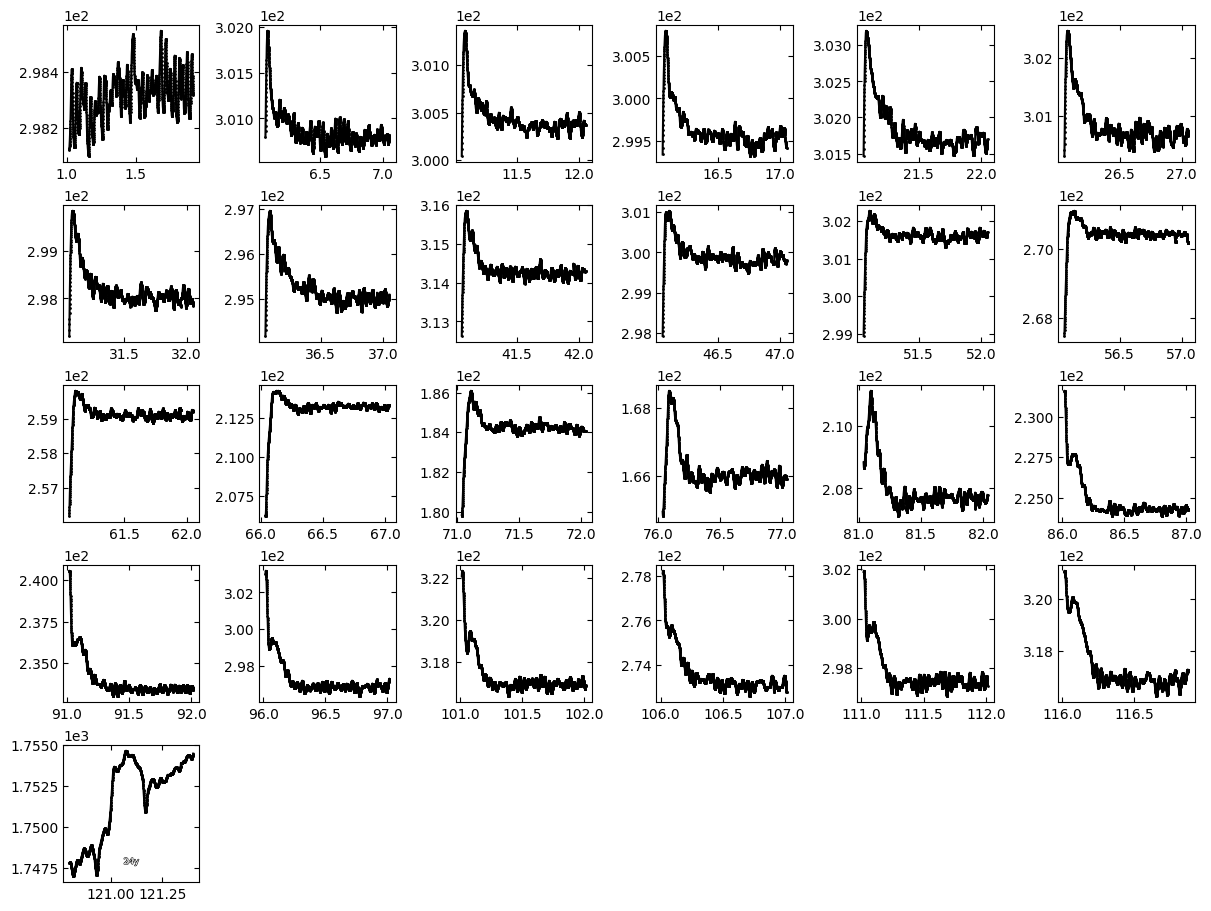

In [104]:
denoise_params = {'savgol_window_order': (51, 3), 'pca_component': None, 'fft_cutoff_order':(5, 1), 'median_kernel_size':51}
curve_params = {'trim_first':0, 'tune_tail':True, 'linear_ratio':0.6, 'convolve_step':15, 'prominence':0.2, 'mode':'full'}
normalize_params = {'I_diff': None, 'unify':True, 'bounds':[0.01, 1], 'p_init':(1, 0.1, 0.4), 'n_std':1}
viz_params = {'viz_denoise': False, 'viz_raw_curves': False, 'viz_processed_curves':True, 'viz_fittings': False, 'viz_ab': False, 'viz_tau': False, 'per_plot':5}
    
laser_freq = 1
camera_freq = 2000

ranges_list = [(0, 124)]
temp_list = ['temp300']
ys_list = []

para_path = './Datasets/J14_PM04_05_06_gaussian_fit_parameters_08252023.h5'
ds_para = RHEED_parameter_dataset(para_path, camera_freq=camera_freq, sample_name='J14')
for temp, ranges in zip(temp_list, ranges_list):
    sample_x, sample_y = ds_para.load_curve(growth=temp, spot='spot_2', metric='img_rec_max', x_start=0)
    # print(temp)
    data = np.stack([sample_x, sample_y], 1)
    data = select_range(data, *ranges)

    parameters_all, x_list_all, info, tau = analyze_rheed_data(data, camera_freq, laser_freq, denoise_params, curve_params, normalize_params, viz_params)
    [xs_all, ys_all, ys_fit_all, ys_nor_all, ys_nor_fit_all, ys_nor_fit_failed_all, labels_all, losses_all] = info
    xs, ys = collect_data(ys_all, mean_length=2000, viz=False)   

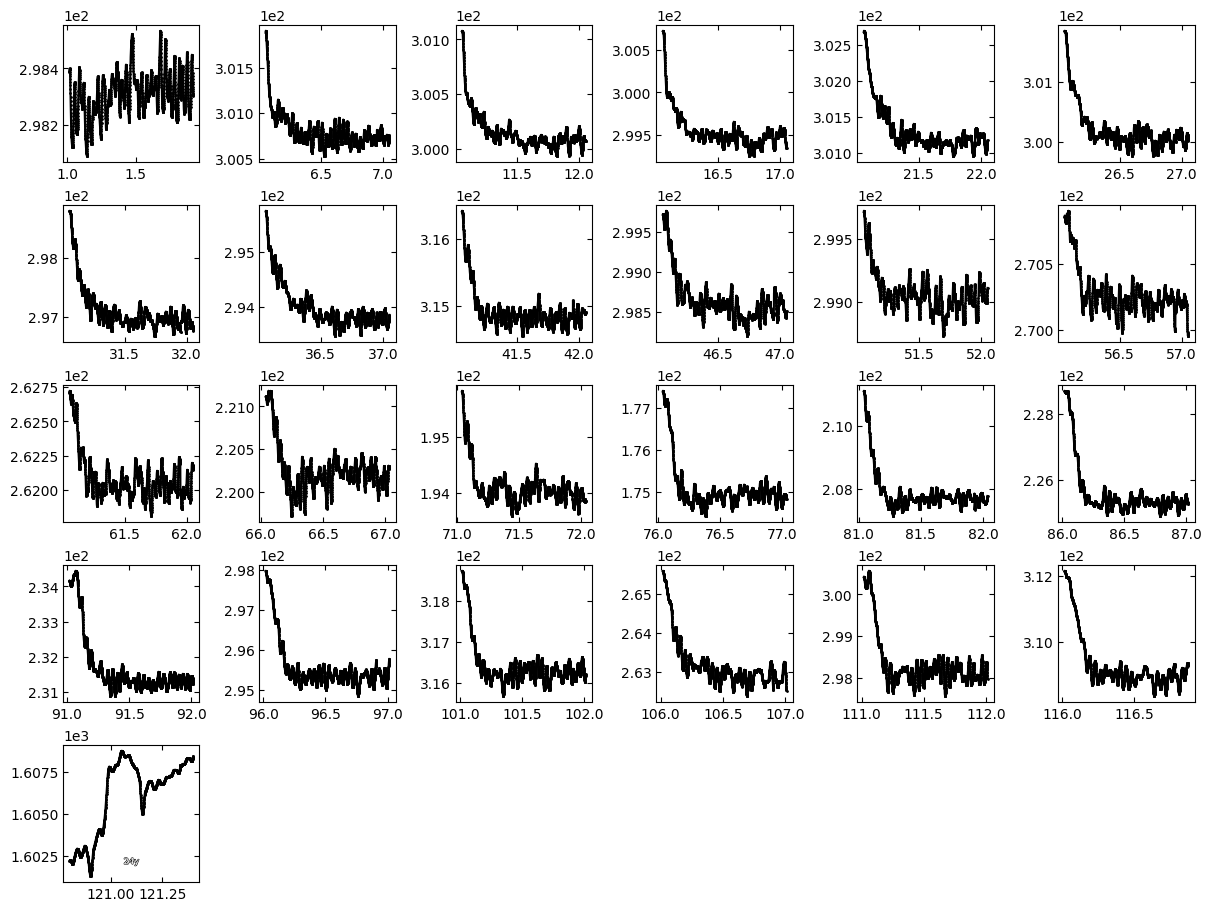

In [105]:
denoise_params = {'savgol_window_order': (51, 3), 'pca_component': None, 'fft_cutoff_order':(5, 1), 'median_kernel_size':51}
curve_params = {'trim_first':'increase_to_decrease', 'tune_tail':True, 'linear_ratio':0.6, 'convolve_step':15, 'prominence':0.2, 'mode':'full'}
normalize_params = {'I_diff': None, 'unify':True, 'bounds':[0.01, 1], 'p_init':(1, 0.1, 0.4), 'n_std':1}
viz_params = {'viz_denoise': False, 'viz_raw_curves': False, 'viz_processed_curves':True, 'viz_fittings': False, 'viz_ab': False, 'viz_tau': False, 'per_plot':5}
    
laser_freq = 1
camera_freq = 2000

ranges_list = [(0, 124)]
temp_list = ['temp300']
ys_list = []

para_path = './Datasets/J14_PM04_05_06_gaussian_fit_parameters_08252023.h5'
ds_para = RHEED_parameter_dataset(para_path, camera_freq=camera_freq, sample_name='J14')
for temp, ranges in zip(temp_list, ranges_list):
    sample_x, sample_y = ds_para.load_curve(growth=temp, spot='spot_2', metric='img_rec_max', x_start=0)
    # print(temp)
    data = np.stack([sample_x, sample_y], 1)
    data = select_range(data, *ranges)

    parameters_all, x_list_all, info, tau = analyze_rheed_data(data, camera_freq, laser_freq, denoise_params, curve_params, normalize_params, viz_params)
    [xs_all, ys_all, ys_fit_all, ys_nor_all, ys_nor_fit_all, ys_nor_fit_failed_all, labels_all, losses_all] = info
    xs, ys = collect_data(ys_all, mean_length=2000, viz=False)   

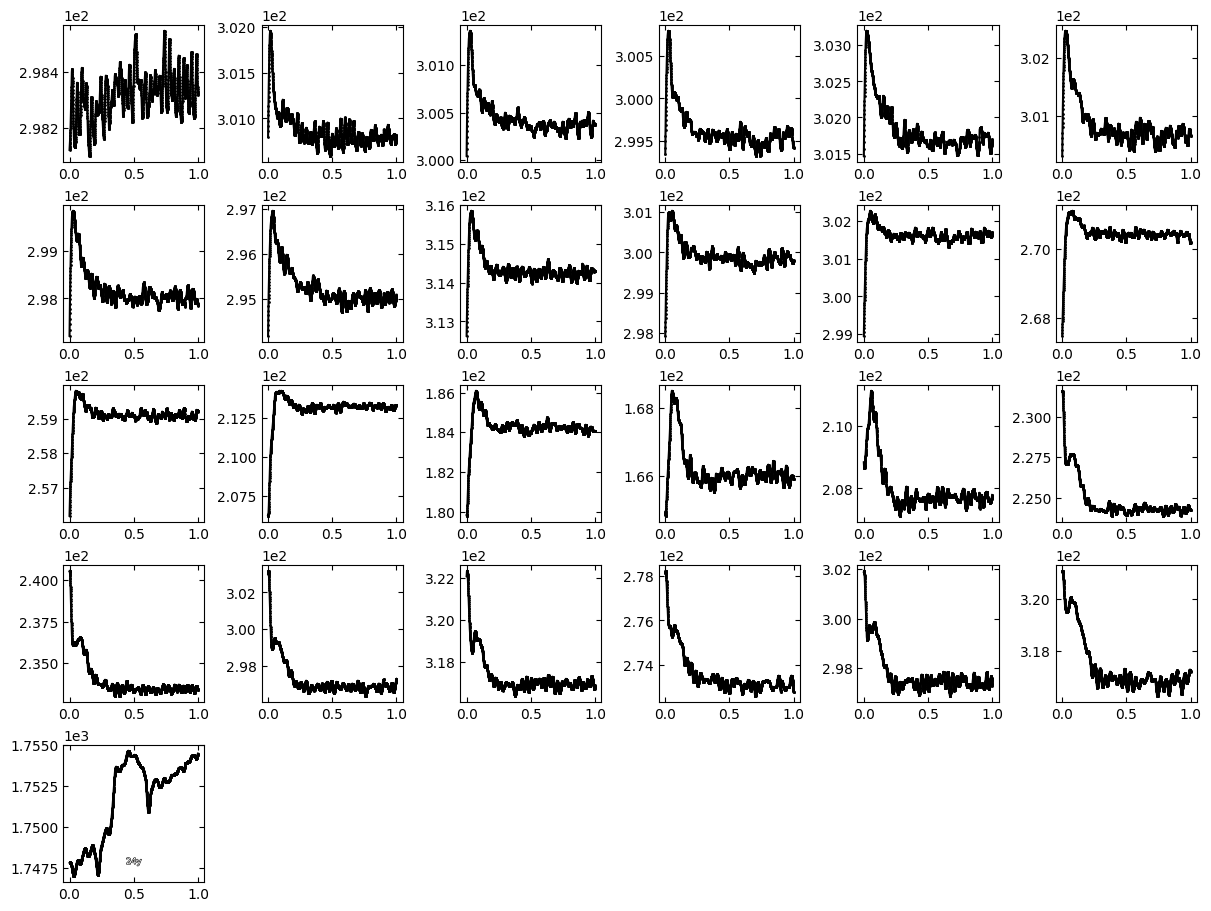

In [16]:
xs_sample, ys_sample = xs[::5], ys[::5].squeeze().detach().numpy()
fig, axes = layout_fig(len(ys_sample), mod=6, figsize=(12,2*len(ys_sample)//6+1), layout='compressed')
Viz.show_grid_plots(axes, xs_sample, ys_sample, labels=None, xlabel=None, ylabel=None, ylim=None, legend=None, color=None)

In [58]:
def find_sign_change(values):
    for i in range(len(values) - 2):
        # print(values[i], values[i + 1], values[i + 2])
        if values[i] < values[i + 1] and values[i + 1] > values[i + 2]:
            return i + 1  # The position where it changes from increase to decrease
    return -1  # Return -1 if no such transition is found

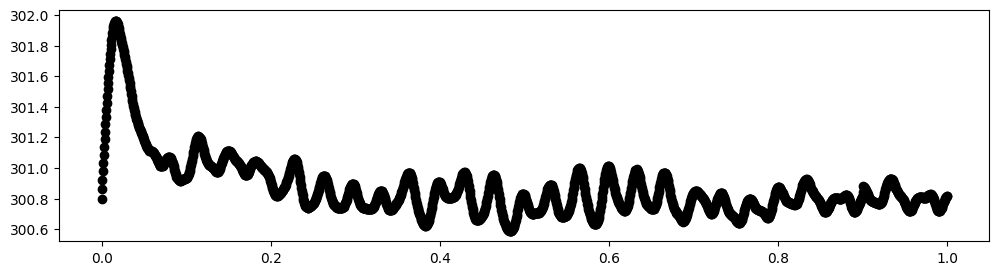

In [59]:
y_target = ys[5].squeeze().detach().numpy()

plt.figure(figsize=(12, 3))
plt.scatter(xs[5], y_target, color='k')

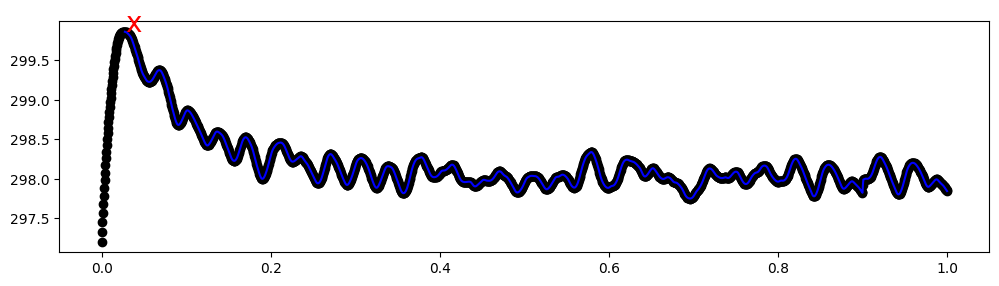

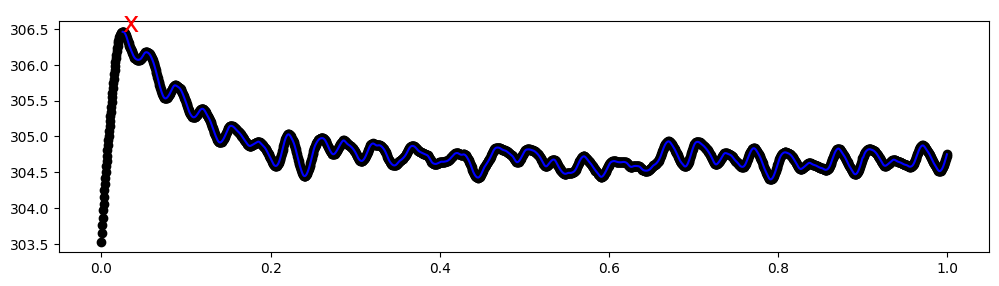

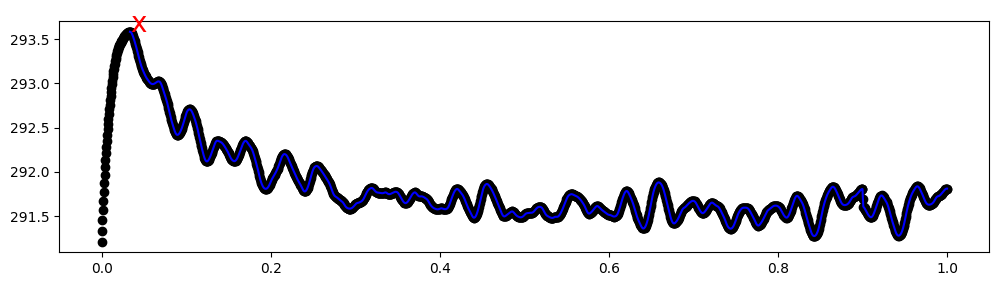

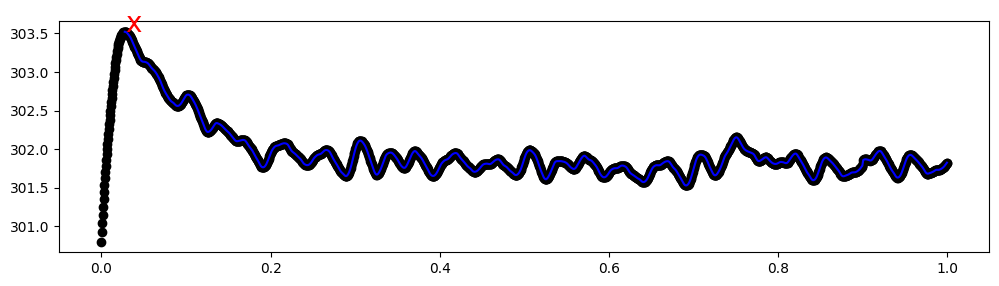

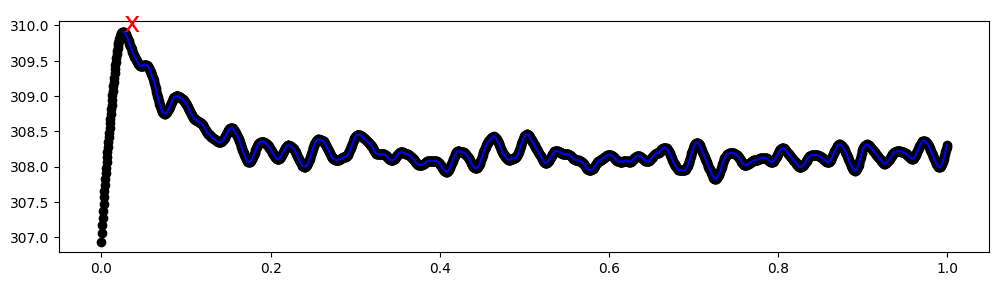

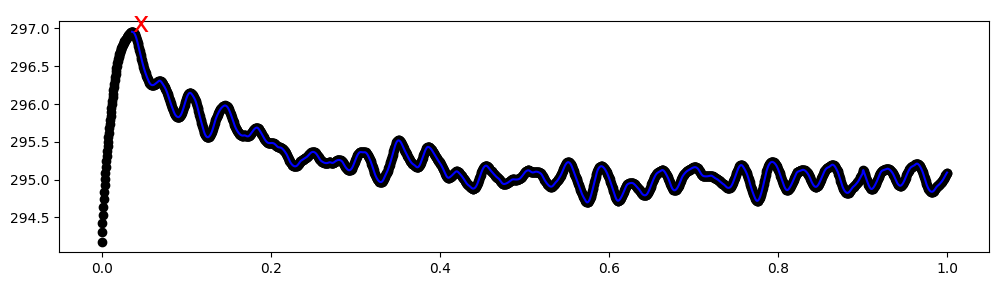

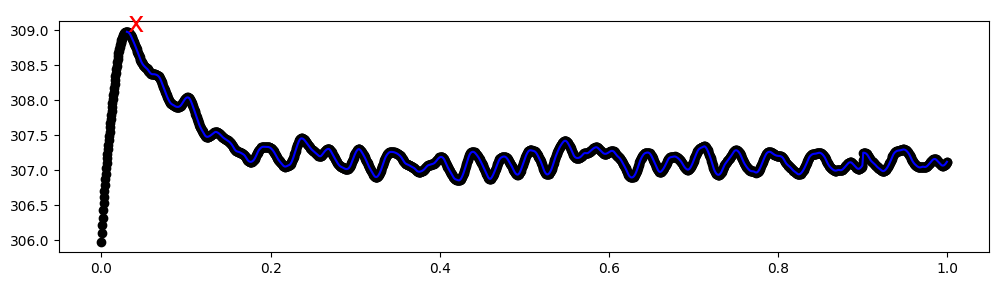

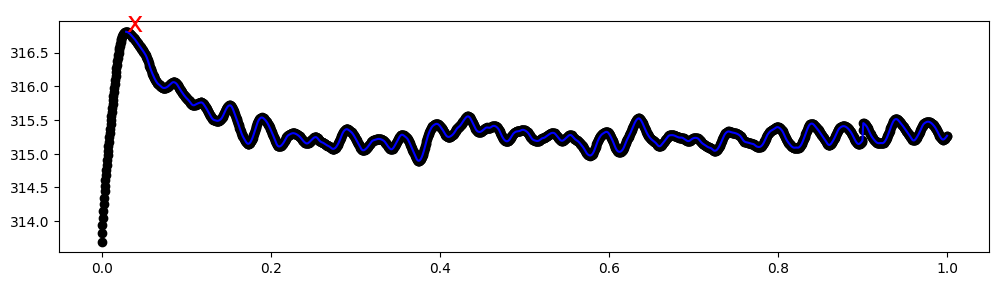

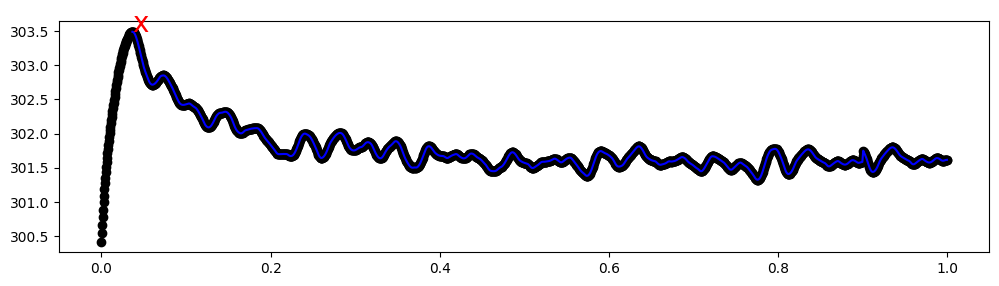

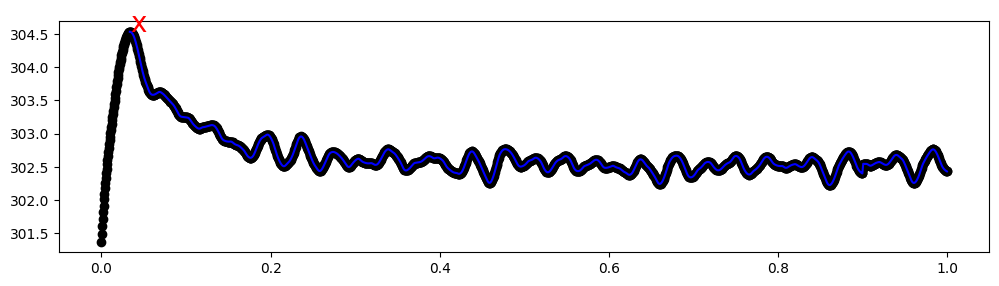

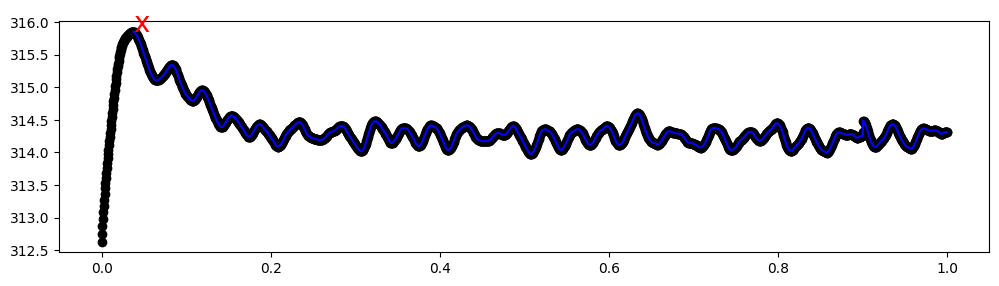

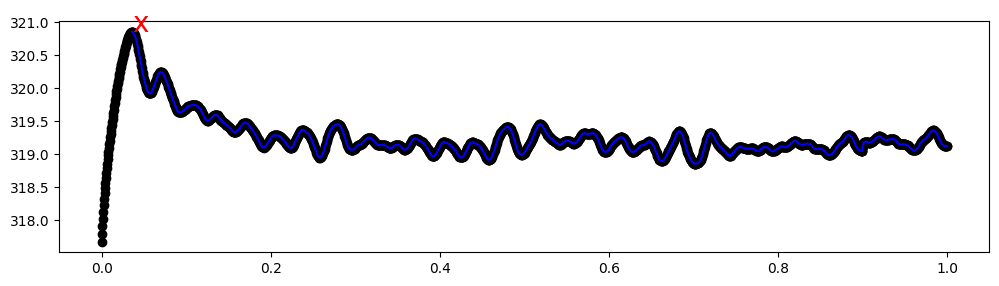

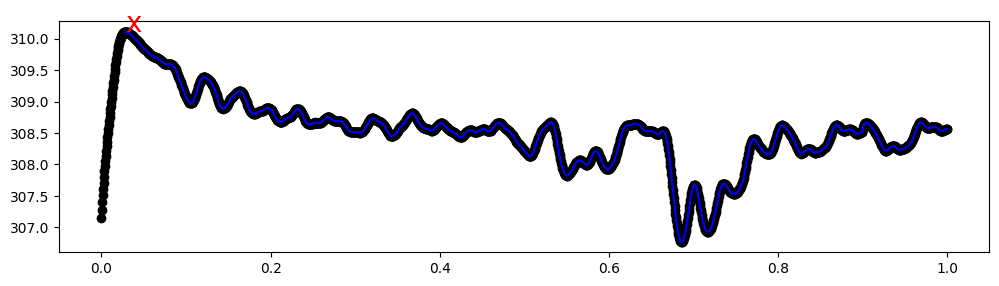

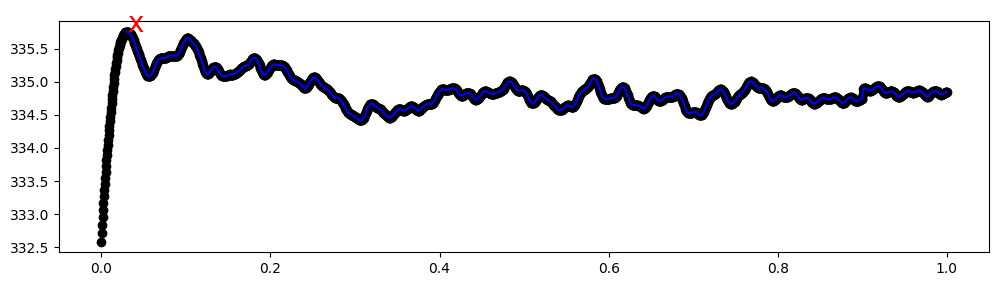

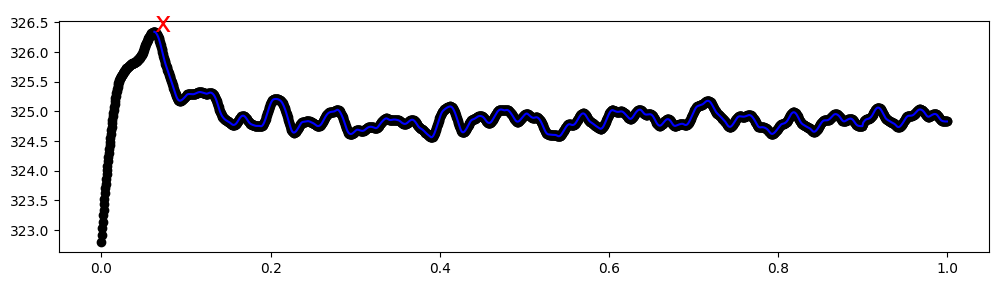

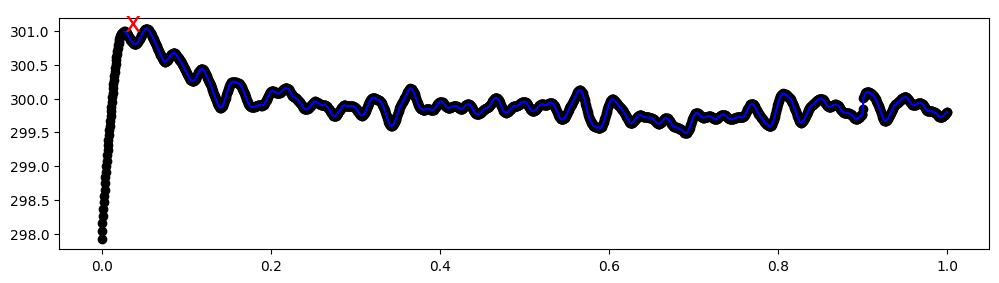

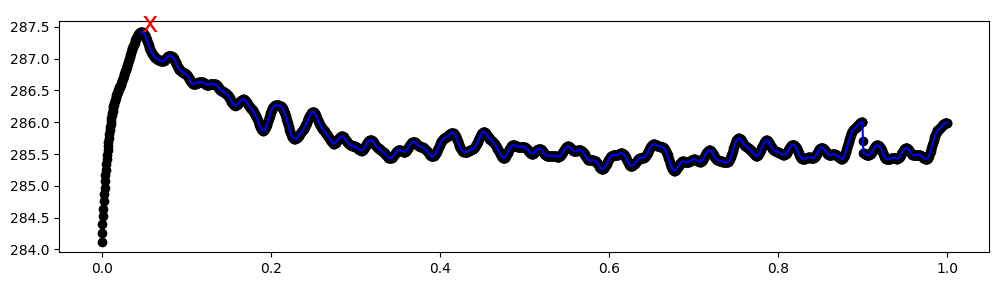

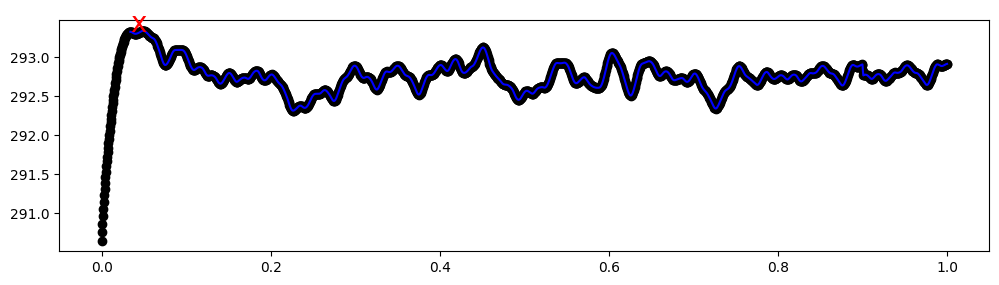

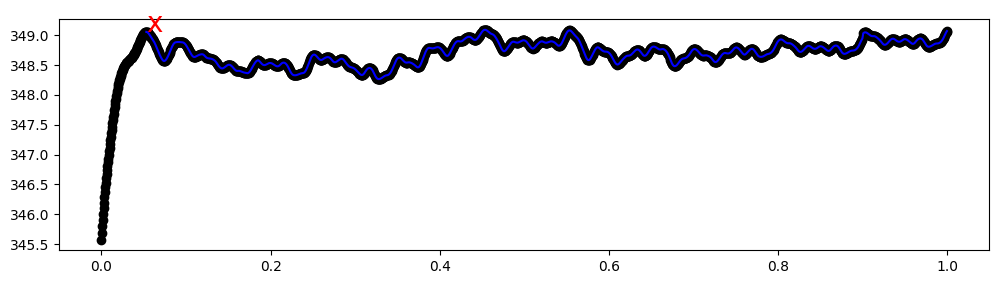

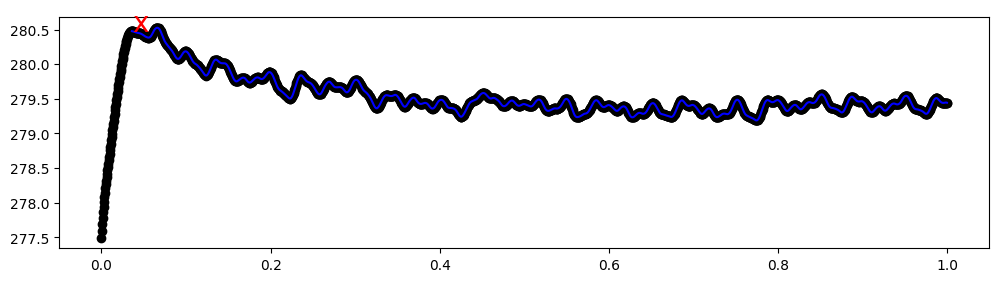

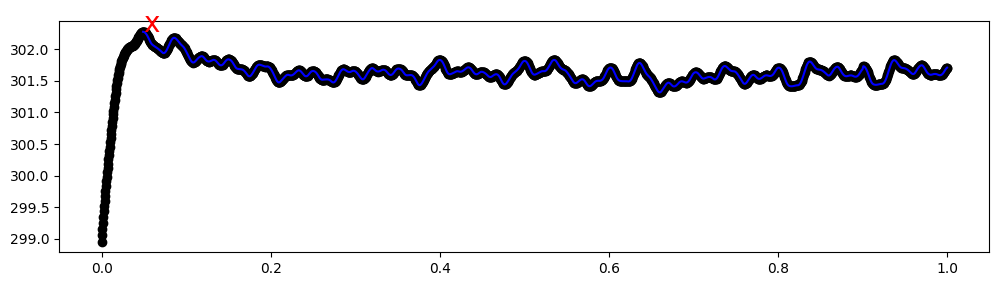

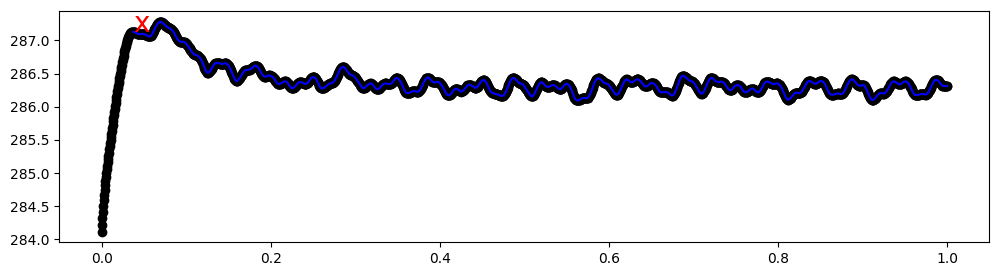

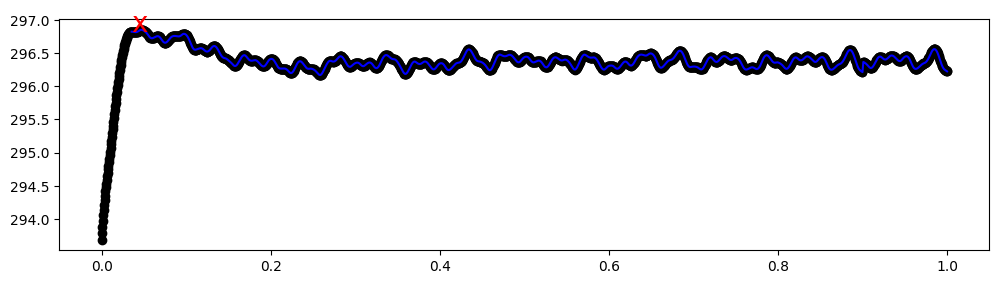

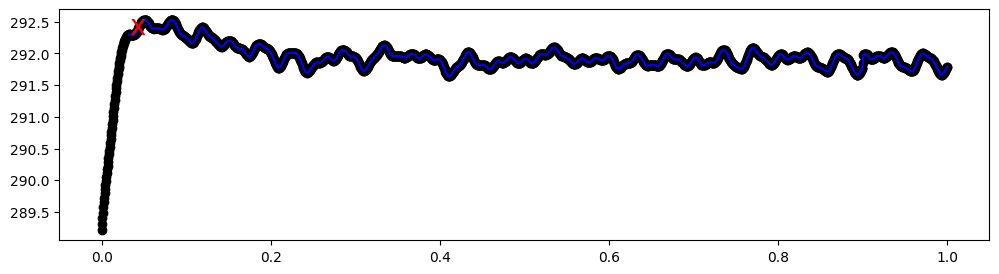

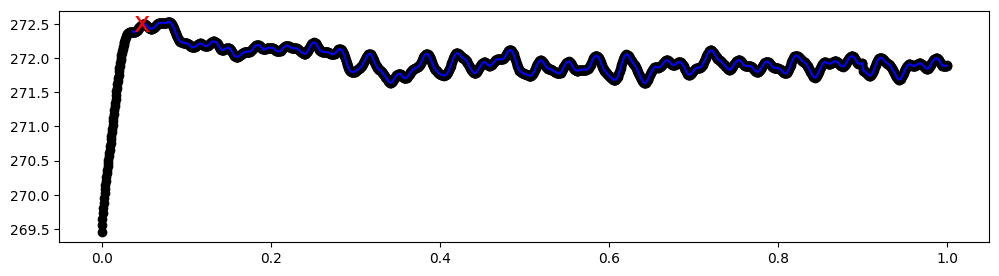

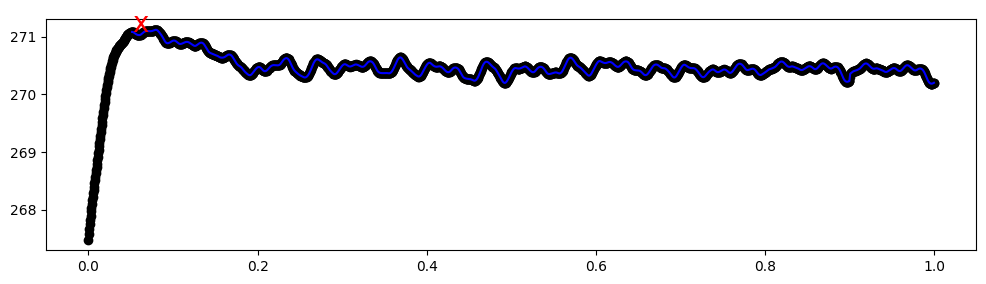

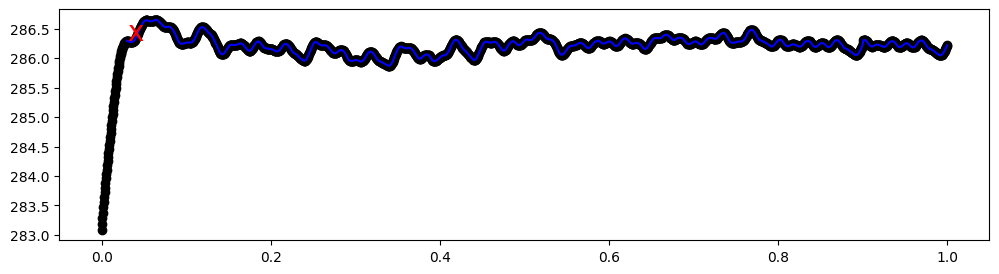

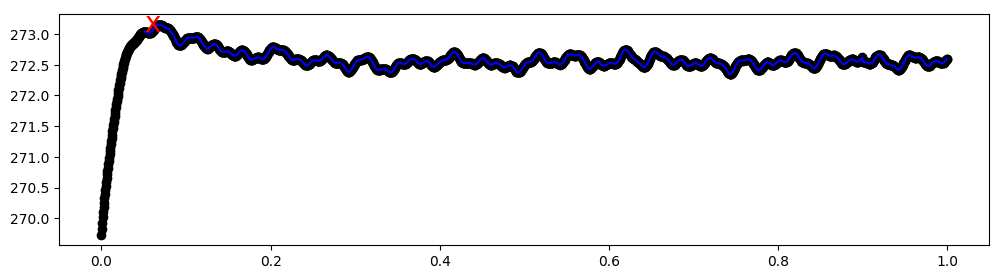

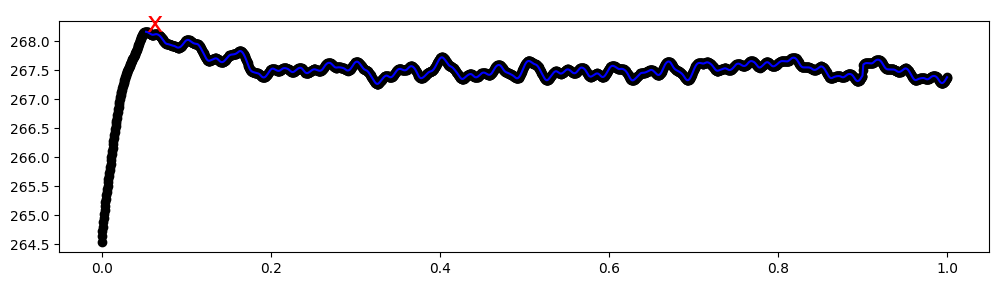

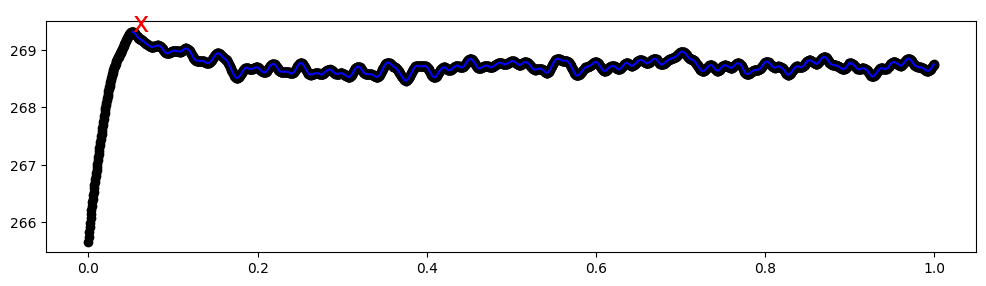

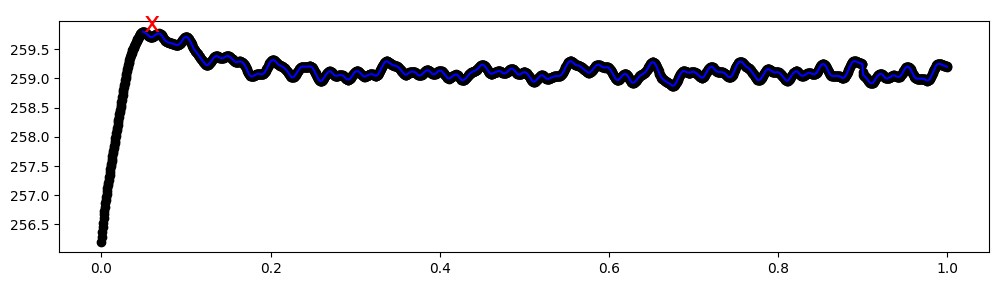

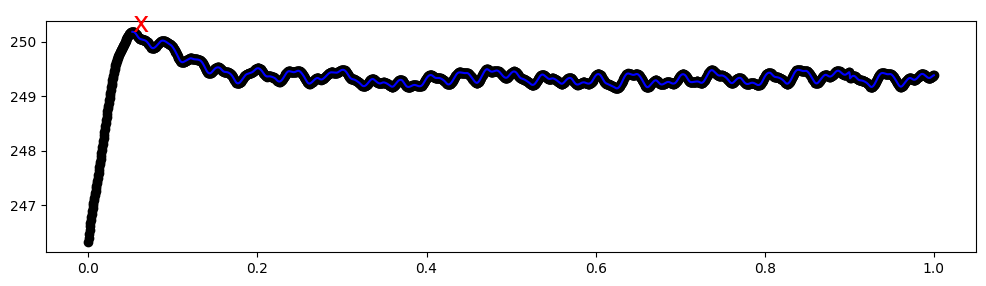

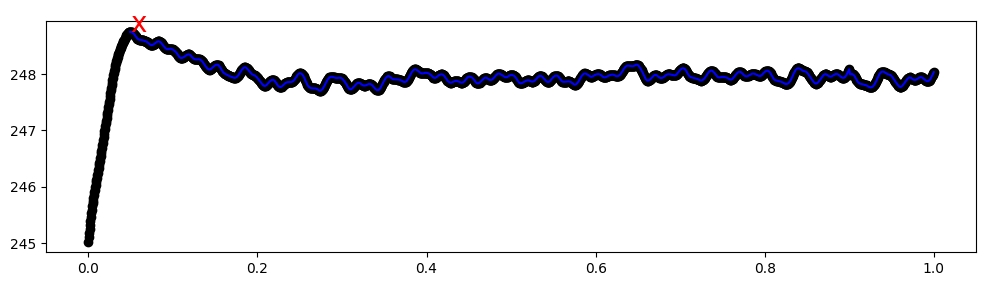

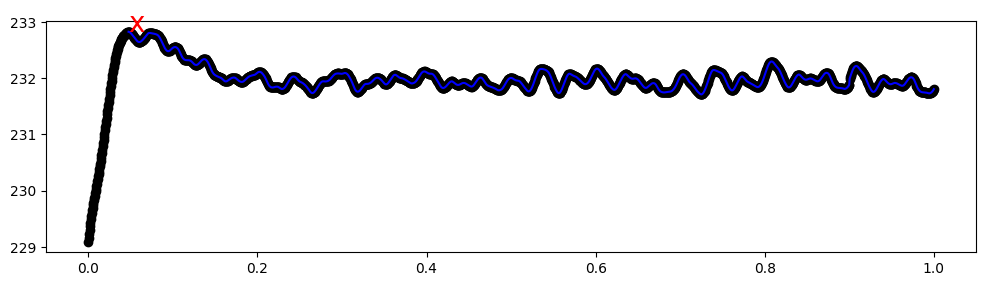

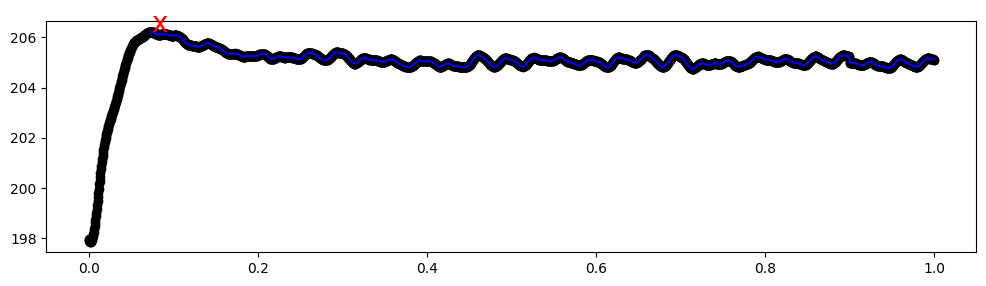

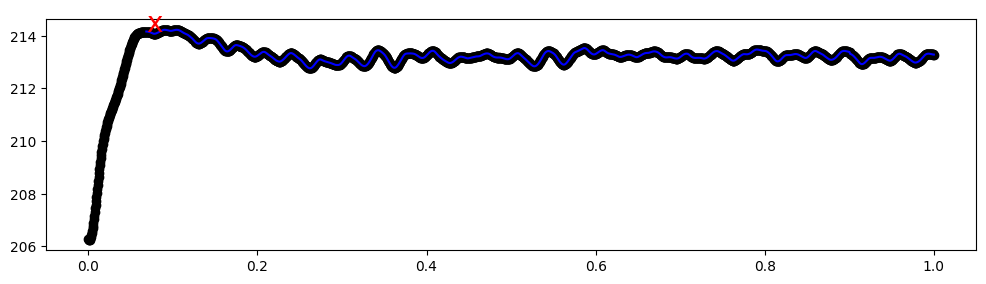

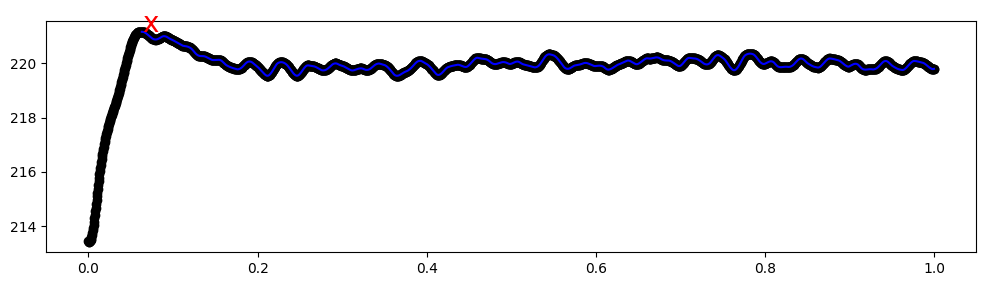

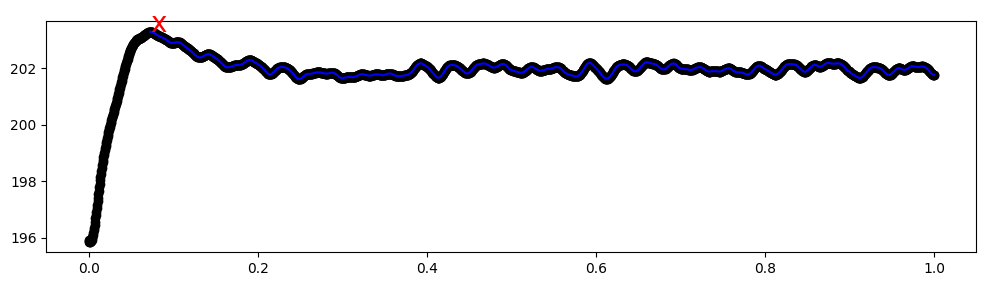

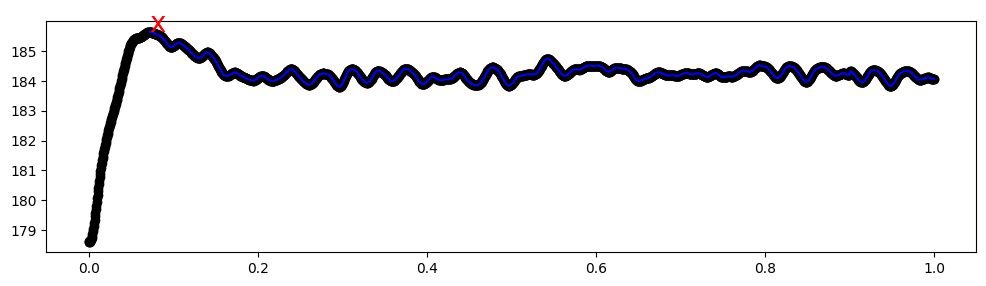

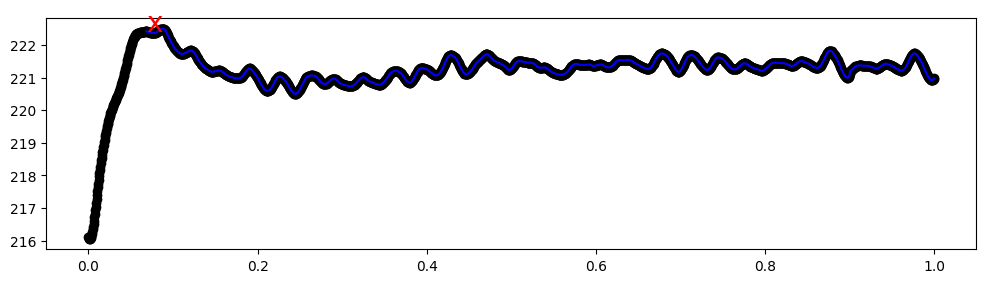

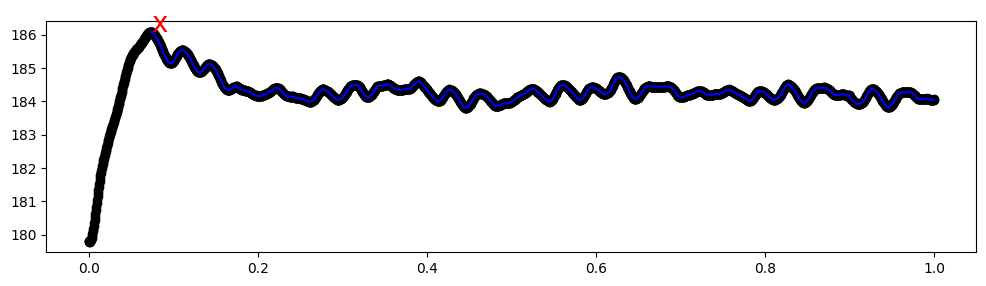

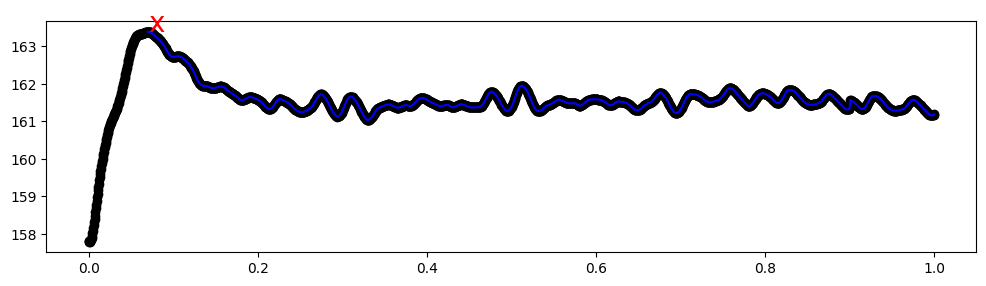

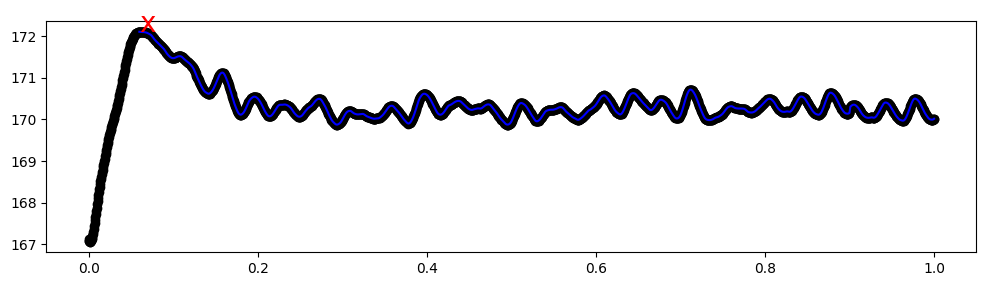

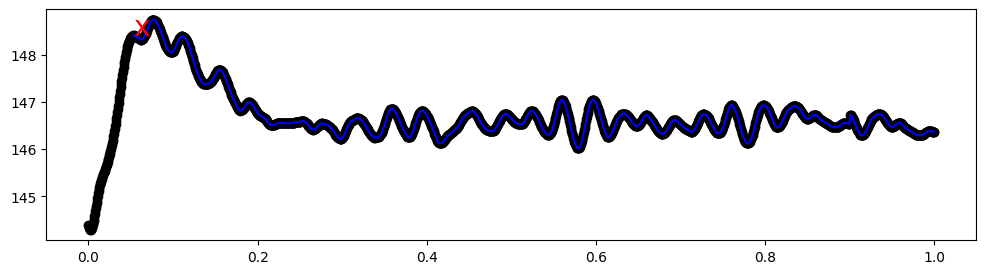

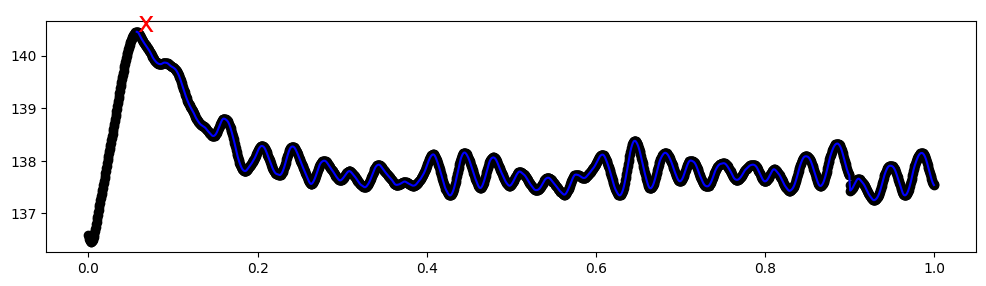

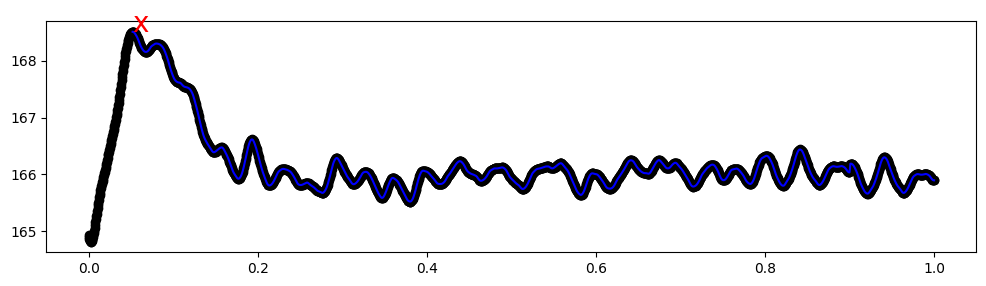

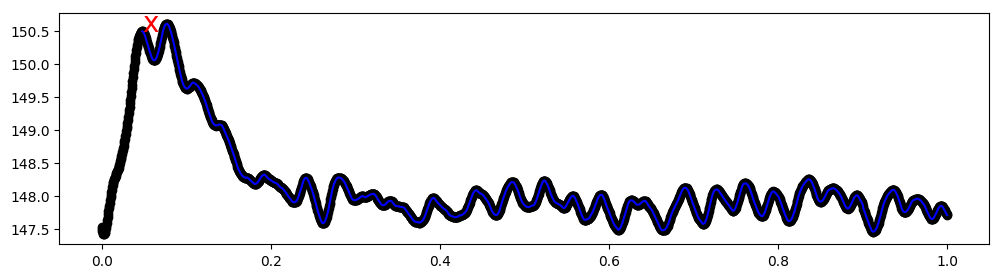

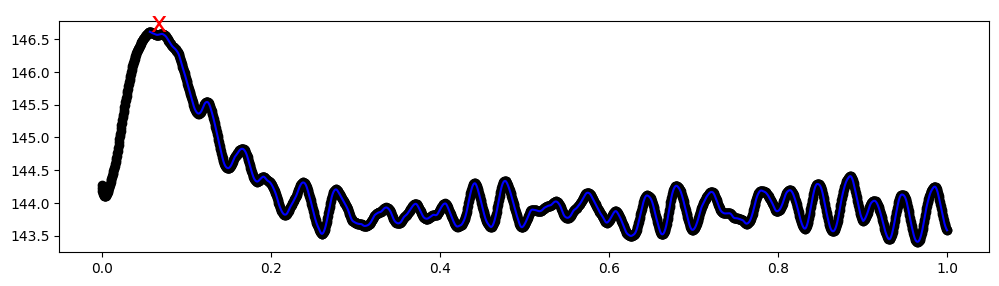

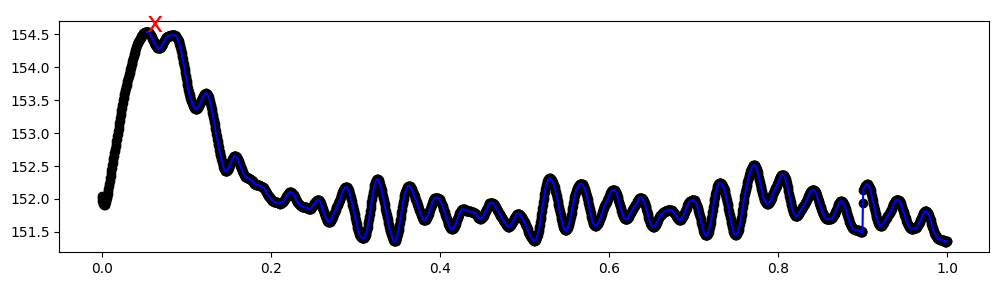

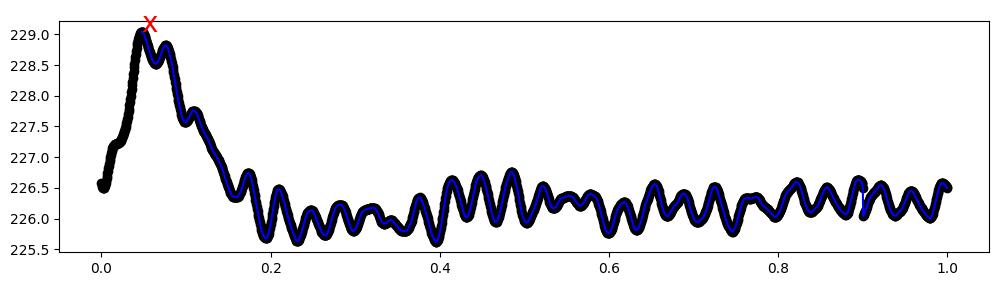

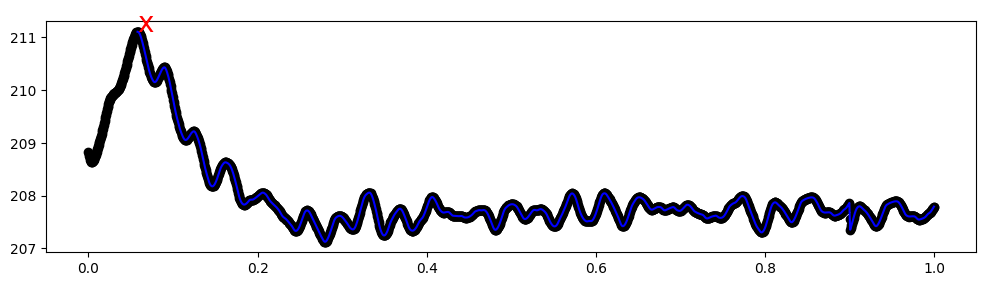

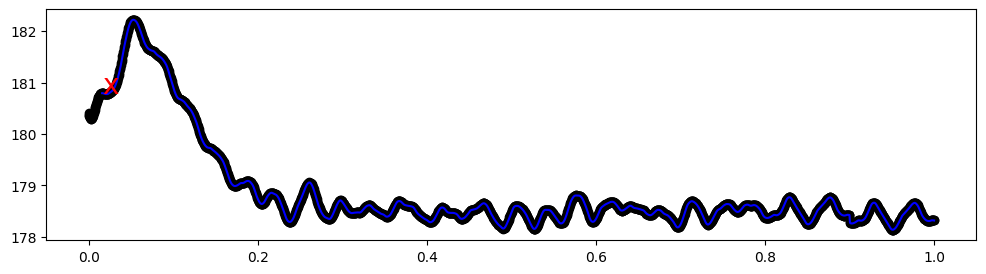

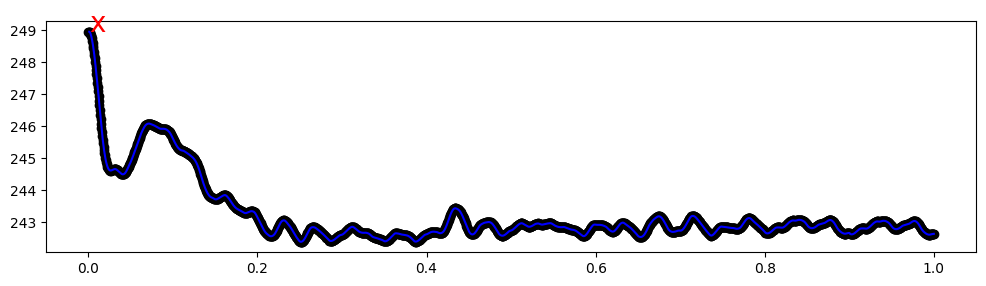

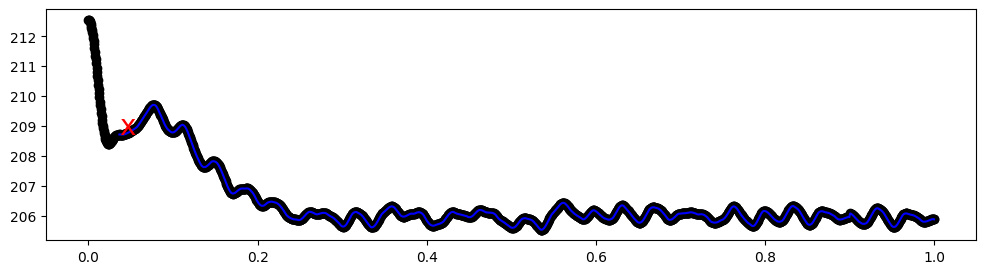

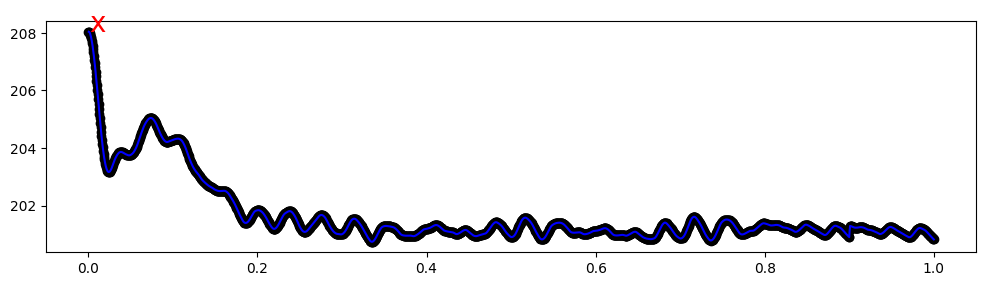

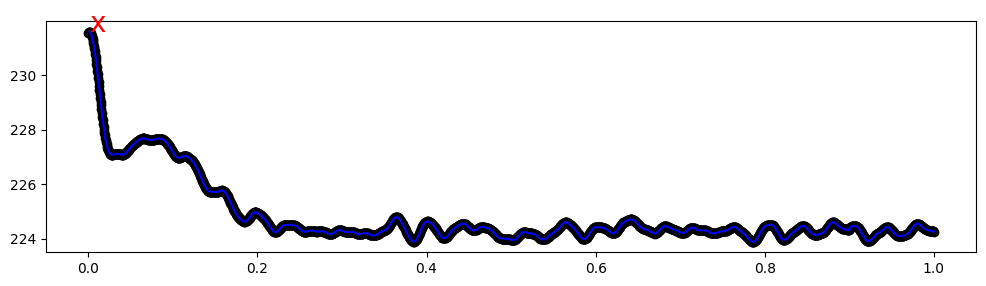

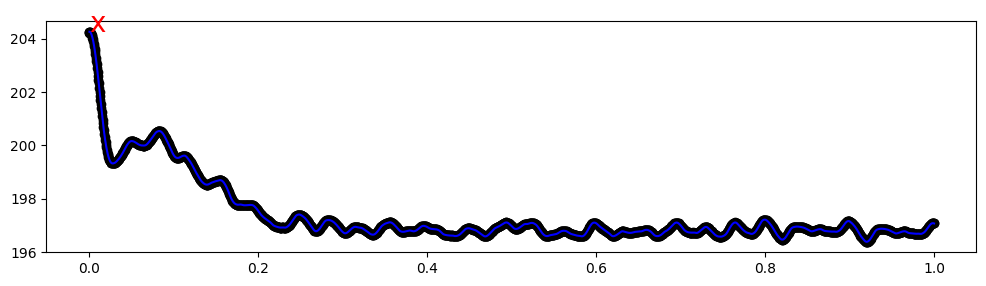

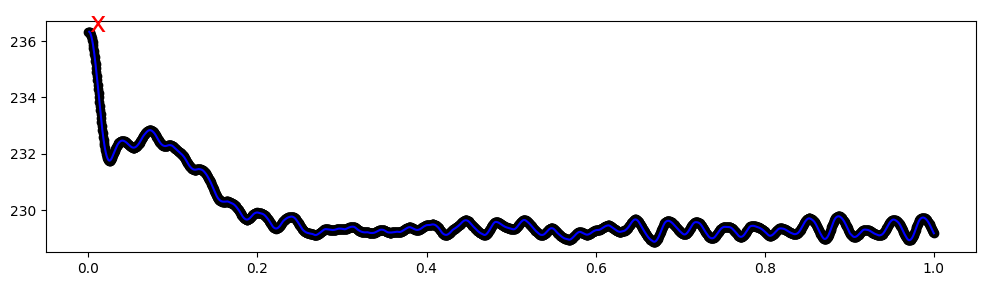

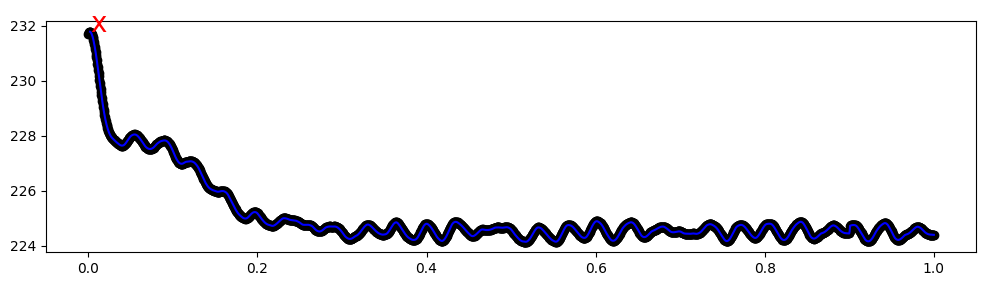

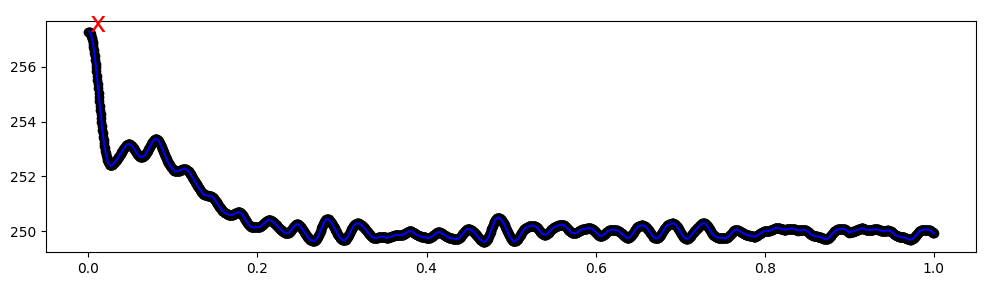

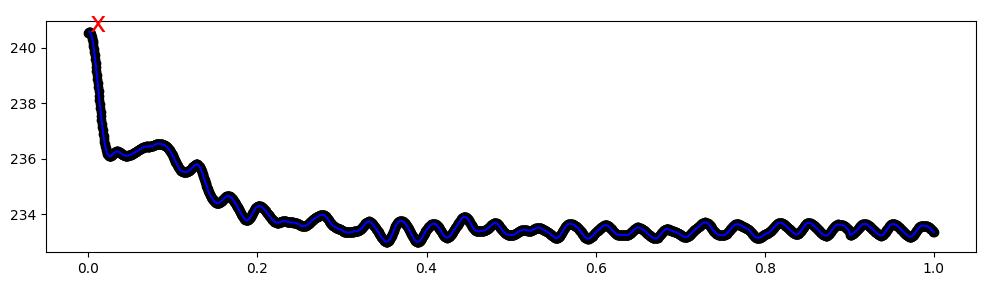

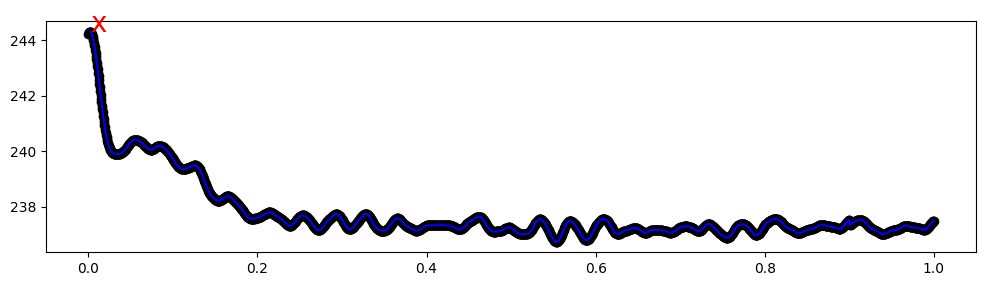

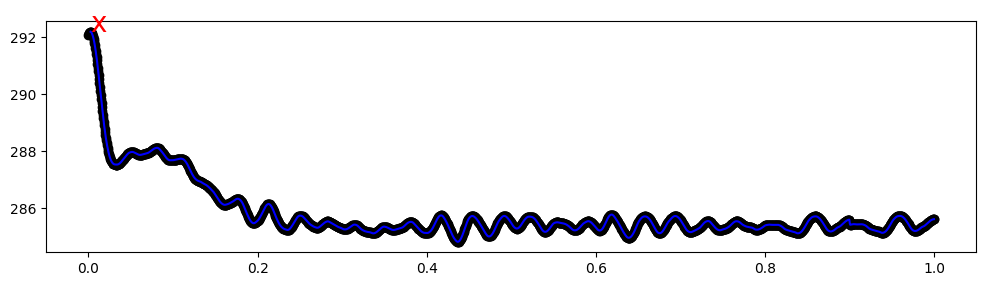

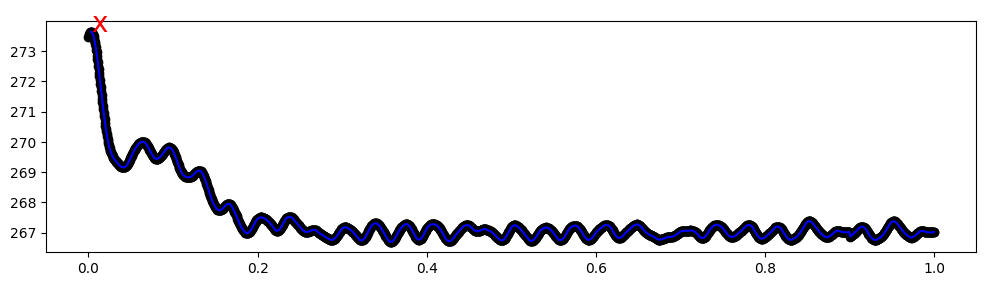

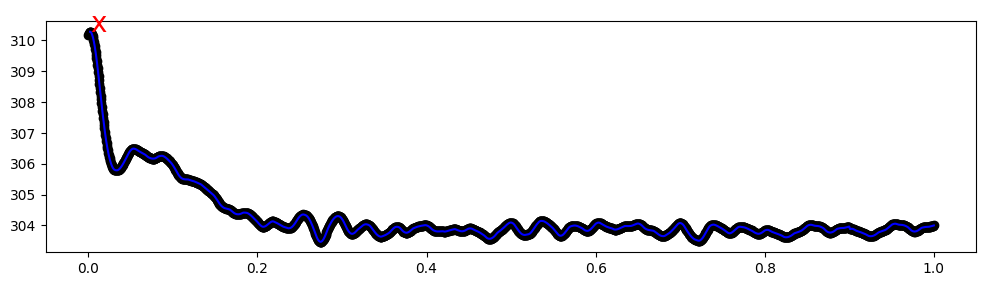

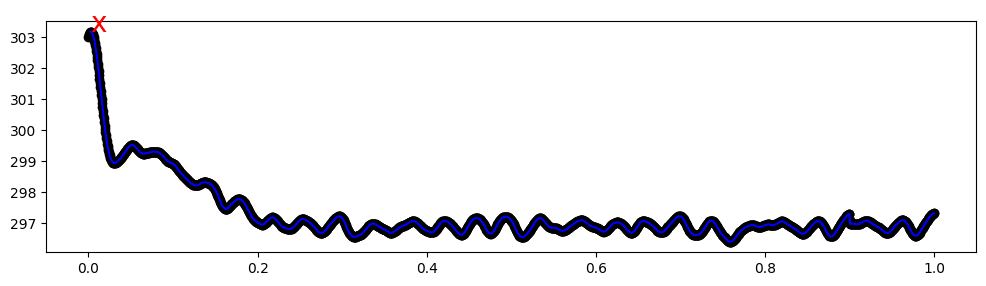

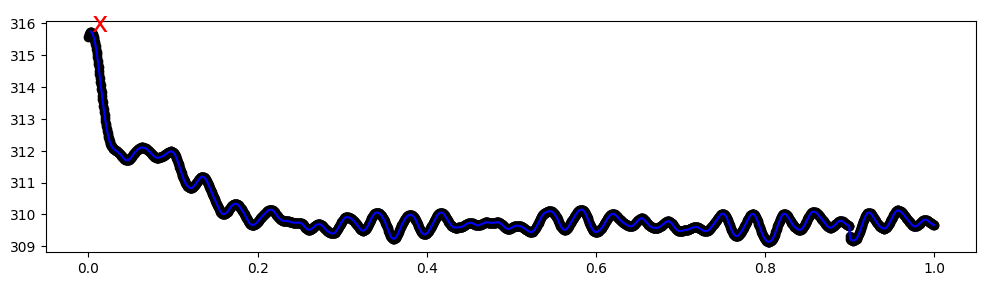

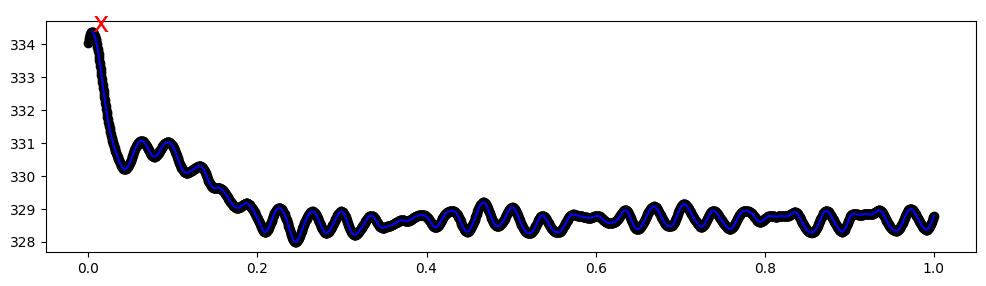

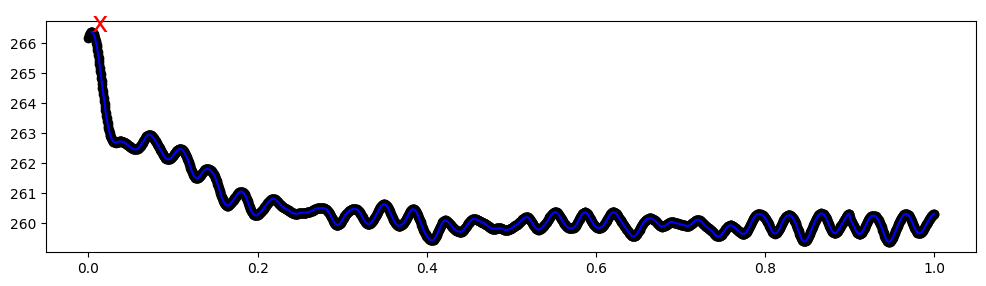

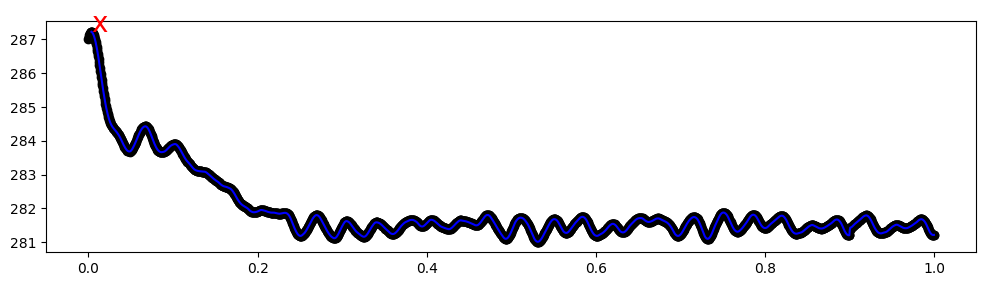

In [61]:
for i in range(30, 100):

    x_target = xs[i]
    y_target = ys[i].squeeze().detach().numpy()
    x_pos = find_sign_change(y_target)

    plt.figure(figsize=(12, 3))
    plt.scatter(x_target, y_target, color='k')
    plt.text(x_target[x_pos], y_target[x_pos], 'x', color='r', fontsize=20)

    x, y = x_target[x_pos:], y_target[x_pos:]

    plt.plot(x, y, color='b')
    plt.show()